In [1]:
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import sys, io

import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
def _get_hidden_neuron_number(i, o):
    return (max(i,o)*(min(i,o)**2))**(1/3)


class Shortcut_Conv(nn.Module):

    def __init__(self, tree, input_dim, output_dim, kernel=(3,3), stride=1):
        super().__init__()
        self.tree = tree
        self._kernel = np.array(kernel, dtype=int)
        self._padding = tuple(((self._kernel-1)/2).astype(int))
        self._stride = stride
        _wd = nn.Conv2d(input_dim, output_dim, self._kernel, stride=self._stride,
                        padding=self._padding, bias=False).weight.data
        ## Shape = OutputDim, InputDim, Kernel0, Kernel1
        self.weight = nn.Parameter(
            torch.empty_like(_wd).copy_(_wd)
        )
        del _wd
    
        ## for removing and freezing neurons
        self.to_remove = None
        self.to_freeze = None
        self.initial_remove = None
        self.initial_freeze = None
        
    def forward(self, x):
        if x.shape[1] > 0 and self.weight.shape[0] > 0:
            return F.conv2d(x, self.weight, stride=self._stride, padding=self._padding)
        ### output dim is 0
        elif self.weight.shape[0] == 0:
            ###             #num_inp  #inp_dim    #feature
            x = torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3], dtype=x.dtype, device=x.device)
            ###       #out_dim #inp_dim            #kernel
            w = torch.zeros(1, 1, self.weight.shape[2], self.weight.shape[3], dtype=x.dtype, device=x.device)
            o = F.conv2d(x, w, stride=self._stride, padding=self._padding)
            return torch.zeros(o.shape[0], 0, o.shape[2], o.shape[3], dtype=x.dtype, device=x.device)
        ### input dim is 0
        elif x.shape[1] == 0:
            ###             #num_inp  #inp_dim    #feature
            x = torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3], dtype=x.dtype, device=x.device)
            ###             #out_dim            #inp_dim            #kernel
            w = torch.zeros(self.weight.shape[0], 1, self.weight.shape[2], self.weight.shape[3], dtype=x.dtype, device=x.device)
            o = F.conv2d(x, w, stride=self._stride, padding=self._padding)
            return o.data
        else:
            raise(f"Unknown shape of input {x.shape} or weight {self.weight.shape}")

#     def decay_std_ratio(self, factor):
#         self.weight.data = self.weight.data - self.tree.decay_rate_std*factor.t()*self.weight.data
        
#     def decay_std_ratio_grad(self, factor):
#         self.weight.grad = self.weight.grad + self.tree.decay_rate_std*factor.t()*self.weight.data
    
    def start_decaying_connection(self, to_remove):
        self.initial_remove = self.weight.data[:, to_remove]
        self.to_remove = to_remove
        self.tree.decay_connection_shortcut.add(self)
        pass
    
    def start_freezing_connection(self, to_freeze):
        self.initial_freeze = self.weight.data[to_freeze, :]
        self.to_freeze = to_freeze
        self.tree.freeze_connection_shortcut.add(self)
        pass
    
    def freeze_connection_step(self):#, to_freeze):
        self.weight.data[self.to_freeze, :] = self.initial_freeze
        pass
    
    def decay_connection_step(self):#, to_remove):
        self.weight.data[:, self.to_remove] = self.initial_remove*self.tree.decay_factor
        pass
     
    def remove_freezed_connection(self, remaining):
        # print(self.weight.data.shape, "removing freezed; ", self.to_freeze)
        _w = self.weight.data[remaining, :]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_freeze = None
        self.to_freeze = None
        pass
    
    def remove_decayed_connection(self, remaining):
        # print(self.weight.data.shape, "removing decayed; ", self.to_remove)
        _w = self.weight.data[:, remaining]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_remove = None
        self.to_remove = None
        pass
    
    def add_input_connection(self, num):
        # print(self.weight.data.shape)
        o, i, k0, k1 = self.weight.data.shape
        _w = torch.cat((self.weight.data, torch.zeros(o, num, k0, k1, dtype=self.weight.data.dtype,
                                                      device=self.weight.data.device)), dim=1)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)
        pass

    def add_output_connection(self, num):
        # print(self.weight.data.shape)
        o, i, k0, k1 = self.weight.data.shape
        stdv = 1. / np.sqrt(i)
        _new = torch.empty(num, i, k0, k1, dtype=self.weight.data.dtype,
                           device=self.weight.data.device).uniform_(-stdv, stdv)
        
        _w = torch.cat((self.weight.data, _new), dim=0)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)        
        pass
    
    def print_network_debug(self, depth):
        print(f"{'║     '*depth}S▚:{depth}[{self.weight.data.shape[1]},{self.weight.data.shape[0]}]")



In [4]:
# class NonLinearity_Conv(nn.Module):

#     def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
#         super().__init__()
#         self.tree = tree
#         self.bias = nn.Parameter(torch.zeros(io_dim))
#         self.actf = actf_obj

#     def forward(self, x):
#         return self.actf(x+self.bias.view(1,-1,1,1))

#     def add_neuron(self, num):
#         _b = torch.cat((self.bias.data, torch.zeros(num, dtype=self.bias.data.dtype,
#                                                     device=self.bias.data.device)))
#         del self.bias
#         self.bias = nn.Parameter(_b)
        
#     def remove_neuron(self, remaining):
#         _b = self.bias.data[remaining]
#         del self.bias
#         self.bias = nn.Parameter(_b)

class NonLinearity_Conv(nn.Module):

    def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.bn = nn.BatchNorm2d(io_dim)
        self.actf = actf_obj

    def forward(self, x):
        ## if empty tensor forward that to next layer.
        if x.shape[1] < 1:
            return x
        return self.actf(self.bn(x))

    def add_neuron(self, num):
        ####https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm2d
        ## running_mean
        _rm = self.bn.running_mean
        _rm = torch.cat((_rm, torch.zeros(num, dtype=_rm.dtype, device=_rm.device)))
        self.bn.running_mean = _rm
        
        ## running_var
        _rv = self.bn.running_var
        _rv = torch.cat((_rv, torch.ones(num, dtype=_rv.dtype, device=_rv.device)))
        self.bn.running_var = _rv
        
        ## weight
        _w = self.bn.weight.data
        _w = torch.cat((_w, torch.ones(num, dtype=_w.dtype, device=_w.device)))
        del self.bn.weight
        self.bn.weight = nn.Parameter(_w)
        
        ## bias
        _b = self.bn.bias.data
        _b = torch.cat((_b, torch.zeros(num, dtype=_b.dtype, device=_b.device)))
        del self.bn.bias
        self.bn.bias = nn.Parameter(_b)
        
        self.bn.num_features += num
        return
        
    def remove_neuron(self, remaining):
        ## running_mean
        _rm = self.bn.running_mean[remaining]
        self.bn.running_mean = _rm
        
        ## running_var
        _rv = self.bn.running_var[remaining]
        self.bn.running_var = _rv
        
        ## weight
        _w = self.bn.weight.data[remaining]
        del self.bn.weight
        self.bn.weight = nn.Parameter(_w)
        
        ## bias
        _b = self.bn.bias.data[remaining]
        del self.bn.bias
        self.bn.bias = nn.Parameter(_b)
        
        self.bn.num_features = len(remaining)
        return

In [5]:
class NonLinearity(nn.Module):

    def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.bias = nn.Parameter(torch.zeros(io_dim))
        self.actf = actf_obj

    def forward(self, x):
        return self.actf(x+self.bias)

    def add_neuron(self, num):
        _b = torch.cat((self.bias.data, torch.zeros(num, dtype=self.bias.data.dtype,
                                                    device=self.bias.data.device)))
        del self.bias
        self.bias = nn.Parameter(_b)
        
    def remove_neuron(self, remaining):
        _b = self.bias.data[remaining]
        del self.bias
        self.bias = nn.Parameter(_b)

In [6]:
class Residual_Conv(nn.Module):

    def __init__(self, tree, input_dim, hidden_dim, output_dim, stride=1, activation=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.hidden_dim = hidden_dim
#         self.stride = stride
        self.del_neurons = 0.
        self.neurons_added = 0

        ## Shortcut or Hierarchical Residual Layer
        self.fc0 = HierarchicalResidual_Conv(self.tree, input_dim, hidden_dim, stride=stride, activation=activation) 
        self.non_linearity = NonLinearity_Conv(self.tree, hidden_dim, activation)
        self.fc1 = HierarchicalResidual_Conv(self.tree, hidden_dim, output_dim, activation=activation)
        self.fc1.shortcut.weight.data *= 0.
        
        self.tree.parent_dict[self.fc0] = self
        self.tree.parent_dict[self.fc1] = self
        self.tree.parent_dict[self.non_linearity] = self
        
        self.hook = None
        self.activations = None
        self.significance = None
        self.count = None
        self.apnz = None
        self.to_remove = None
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.non_linearity(x)
        self.activations = x.data
        x = self.fc1(x)
        return x
    
    def start_computing_significance(self):
        self.significance = 0.
        self.count = 0
        self.apnz = 0
        self.hook = self.non_linearity.register_backward_hook(self.compute_neuron_significance)
        pass
            
    def finish_computing_significance(self):
        self.hook.remove()
        self.significance = self.significance#/self.count
#         print(f"Significance before rethinking(apnz)\n{self.significance}")
#         print(f"Apnz\n{self.apnz}")
        if isinstance(self.non_linearity.actf, nn.ReLU):
            self.apnz = self.apnz/self.count
            self.significance = self.significance*(1-self.apnz) * 4 ## tried on desmos.
#         print(f"Significance after rethinking(apnz)\n{self.significance}")
#         self.count = None

        self.hook = None
        pass
    
    def compute_neuron_significance(self, _class, grad_input, grad_output):
        with torch.no_grad():
            z = torch.sum(grad_output[0].data*self.activations, dim=(2,3))
#             self.significance += z.pow(2).sum(dim=0)
            self.significance += z.abs().sum(dim=0)
#             self.significance += z.abs().pow(0.8).sum(dim=0)
#             print(f"SIG ACT:\n{float(self.activations.abs().mean())}")
#             print(f"GRAD Mean, Std:\n{float(grad_output[0].data.abs().mean()), float(grad_output[0].data.std())}")

            if isinstance(self.non_linearity.actf, nn.ReLU):
                self.count += grad_output[0].shape[0]*grad_output[0].shape[2]*grad_output[0].shape[3]
        #         self.apnz += torch.count_nonzero(self.activations.data, dim=0)
                self.apnz += torch.sum(self.activations > 0., dim=(0,2,3), dtype=z.dtype).to(z.device)
        pass
    
    def identify_removable_neurons(self, below=None, above=None, mask=None):
        if self.to_remove is not None:
            print("First remove all previous less significant neurons")
            return
        if mask is None:
            mask = torch.zeros(self.significance.numel(), dtype=torch.bool)
        if below:
            mask = torch.logical_or(mask,self.significance<=below)
        if above:
            mask = torch.logical_or(mask,self.significance>above)
            
        print(f"Significance:\n{self.significance}\nPrune:\n{mask}")
            
        self.to_remove = torch.nonzero(mask).reshape(-1)
        if len(self.to_remove)>0:
            self.fc0.start_freezing_connection(self.to_remove)
            self.fc1.start_decaying_connection(self.to_remove)
            self.tree.remove_neuron_residual.add(self)
            return len(self.to_remove)
        
        self.to_remove = None
        return 0

    def remove_decayed_neurons(self):
        remaining = []
        for i in range(self.hidden_dim):
            if i not in self.to_remove:
                remaining.append(i)
        
        self.non_linearity.remove_neuron(remaining)
        self.fc0.remove_freezed_connection(remaining)
        self.fc1.remove_decayed_connection(remaining)
        
        self.neurons_added -= len(self.to_remove)
        self.hidden_dim = len(remaining)
        self.to_remove = None
        pass
    
    def compute_del_neurons(self):
        self.del_neurons = (1-self.tree.beta_del_neuron)*self.neurons_added \
                            + self.tree.beta_del_neuron*self.del_neurons
        self.neurons_added = 0
        return
    
    def add_hidden_neuron(self, num):
        self.fc0.add_output_connection(num)
        self.non_linearity.add_neuron(num)
        self.fc1.add_input_connection(num)
        
        self.hidden_dim += num
        self.neurons_added += num
        pass

    def morph_network(self):
        self.fc0.morph_network()
        self.fc1.morph_network()
#         max_dim = np.ceil((self.tree.parent_dict[self].input_dim+\
#             self.tree.parent_dict[self].output_dim)/2)
        max_dim = _get_hidden_neuron_number(self.tree.parent_dict[self].input_dim,
            self.tree.parent_dict[self].output_dim)+1
        if self.hidden_dim <= max_dim:
            if self.fc0.residual is None:
                if self.fc0 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc0)
            if self.fc1.residual is None:
                if self.fc1 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc1)
        return 

    def print_network_debug(self, depth):
        print(f"{'║     '*depth}R▚:{depth}[{self.hidden_dim}|{self.non_linearity.bias.data.shape[0]}]")
        self.fc0.print_network_debug(depth+1)
        self.fc1.print_network_debug(depth+1)
        
    def print_network(self, pre_string):
        self.fc0.print_network(pre_string)
        print(f"{pre_string}{self.hidden_dim}")
        self.fc1.print_network(pre_string)
        return

In [7]:
a = torch.randn(10, 3)*0.
a.std()

tensor(0.)

In [8]:
class HierarchicalResidual_Conv(nn.Module):

    def __init__(self, tree, input_dim, output_dim, stride=1, activation=nn.ReLU()):
        super().__init__()

        self.tree = tree
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.stride = 1
        
        self.activation = activation
        
        ## this can be Shortcut Layer or None
        self.shortcut = Shortcut_Conv(tree, self.input_dim, self.output_dim, stride=self.stride).to(self.tree.device)
        self.tree.parent_dict[self.shortcut] = self
        
        self.residual = None ## this can be Residual Layer or None
        ##### only one of shortcut or residual can be None at a time
        self.forward = self.forward_shortcut
        
        self.std_ratio = 0. ## 0-> all variation due to shortcut, 1-> residual
        self.target_std_ratio = 0. ##
    
    def forward_both(self, r):
        s = self.shortcut(r)
        r = self.residual(r)

        if self.residual.hook is None: ### dont execute when computing significance
            s_std = torch.std(s, dim=(0,2,3), keepdim=True).reshape(1, -1)
            r_std = torch.std(r, dim=(0,2,3), keepdim=True).reshape(1, -1)
            stdr = r_std/(s_std+r_std)

            self.std_ratio = self.tree.beta_std_ratio*self.std_ratio + (1-self.tree.beta_std_ratio)*stdr.data
            if r_std.min() > 1e-9:
                ## recover for the fact that when decaying neurons, target ratio should also be reducing
                if self.tree.total_decay_steps:
                    i, o = self.shortcut.weight.shape[1],self.shortcut.weight.shape[0]
                    if self.shortcut.to_remove is not None:
                        i -= len(self.shortcut.to_remove)
                    if self.shortcut.to_freeze is not None:
                        o -= len(self.shortcut.to_freeze)
                    h = self.residual.hidden_dim
                    if self.residual.to_remove is not None:
                        h -= len(self.residual.to_remove)
                    
#                     tr = h/np.ceil((i+o)/2 +1)
                    tr = h/_get_hidden_neuron_number(i, o)
                    self.compute_target_std_ratio(tr)
                else:
                    self.compute_target_std_ratio()
                self.get_std_loss(stdr)
        return s+r
    
    def forward_shortcut(self, x):
        return self.shortcut(x)
    
    def forward_residual(self, x):
        self.compute_target_std_ratio()
        return self.residual(x)
    
    def compute_target_std_ratio(self, tr = None):
        if tr is None:
#             tr = self.residual.hidden_dim/np.ceil((self.input_dim+self.output_dim)/2 +1)
            tr = self.residual.hidden_dim/_get_hidden_neuron_number(self.input_dim, self.output_dim)
#             tr = self.residual.hidden_dim/np.ceil(self.output_dim/2 +1)

        tr = np.clip(tr, 0., 1.)
        self.target_std_ratio = self.tree.beta_std_ratio*self.target_std_ratio +\
                                (1-self.tree.beta_std_ratio)*tr
        pass        
    
    def get_std_loss(self, stdr):
        del_std = self.target_std_ratio-stdr
        del_std_loss = (del_std**2 + torch.abs(del_std)).mean()
#         del_std_loss = (del_std**2).mean()
        self.tree.std_loss += del_std_loss
        return
            
    def start_freezing_connection(self, to_freeze):
        if self.shortcut:
            self.shortcut.start_freezing_connection(to_freeze)
        if self.residual:
            self.residual.fc1.start_freezing_connection(to_freeze)
        pass
        
    def start_decaying_connection(self, to_remove):
        if self.shortcut:
            self.shortcut.start_decaying_connection(to_remove)
        if self.residual:
            self.residual.fc0.start_decaying_connection(to_remove)
        pass
    
    def remove_freezed_connection(self, remaining):
        if self.shortcut:
            self.shortcut.remove_freezed_connection(remaining)
        if self.residual:
            self.residual.fc1.remove_freezed_connection(remaining)
            if self.shortcut: self.std_ratio = self.std_ratio[:, remaining]
        self.output_dim = len(remaining)
        pass
    
    def remove_decayed_connection(self, remaining):
        if self.shortcut:
            self.shortcut.remove_decayed_connection(remaining)
        if self.residual:
            self.residual.fc0.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        if self.shortcut:
            self.shortcut.add_input_connection(num)
        if self.residual:
            self.residual.fc0.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        if self.shortcut:
            self.shortcut.add_output_connection(num)
        if self.residual:
            self.residual.fc1.add_output_connection(num)
            # if torch.is_tensor(self.std_ratio):
            if self.shortcut:
                self.std_ratio = torch.cat((self.std_ratio, torch.zeros(1, num, device=self.tree.device)), dim=1)

    def add_hidden_neuron(self, num):
        if num<1: return
        
        if self.residual is None:
            # print(f"Adding {num} hidden units.. in new residual_layer")
            self.residual = Residual_Conv(self.tree, self.input_dim,
                                          num, self.output_dim, stride=self.stride,
                                          activation=self.activation).to(self.tree.device)
            
            self.tree.parent_dict[self.residual] = self
            if self.shortcut is None:
                self.forward = self.forward_residual
                self.std_ratio = 1.
            else:
                self.forward = self.forward_both
                self.std_ratio = torch.zeros(1, self.output_dim, device=self.tree.device)
                
        else:
            # print(f"Adding {num} hidden units..")
            self.residual.add_hidden_neuron(num)
        return
    
    def maintain_shortcut_connection(self):
        if self.residual is None: return
        
        if self.shortcut:
            if self.std_ratio.min()>0.98 and self.target_std_ratio>0.98:
                del self.tree.parent_dict[self.shortcut]
                del self.shortcut
                self.shortcut = None
                self.forward = self.forward_residual
                self.std_ratio = 1.
            
        elif self.target_std_ratio<0.95:
            self.shortcut = Shortcut_Conv(self.tree, self.input_dim, self.output_dim, stride=self.stride)
            self.shortcut.weight.data *= 0.
            self.forward = self.forward_both
            
        self.residual.fc0.maintain_shortcut_connection()
        self.residual.fc1.maintain_shortcut_connection()
        
    def morph_network(self):
        if self.residual is None: return
        
        if self.residual.hidden_dim < 1:
            del self.tree.parent_dict[self.residual]
            del self.residual
            ### its parent (Residual_Conv) removes it from dynamic list if possible
            self.residual = None
            self.forward = self.forward_shortcut
            self.std_ratio = 0.
            return
        
#         max_dim = np.ceil((self.input_dim+self.output_dim)/2)
        # max_dim = min((self.input_dim, self.output_dim))+1
        max_dim = _get_hidden_neuron_number(self.input_dim, self.output_dim) + 1 
        # print("MaxDIM", max_dim, self.residual.hidden_dim)
        if self.residual.hidden_dim > max_dim:
            self.tree.DYNAMIC_LIST.add(self.residual.fc0)
            self.tree.DYNAMIC_LIST.add(self.residual.fc1)
            # print("Added", self.residual)
            
        # self.residual.fc0.morph_network()
        # self.residual.fc1.morph_network()
        self.residual.morph_network()
        
    def print_network_debug(self, depth):
        stdr = self.std_ratio
        if torch.is_tensor(self.std_ratio):
            stdr = self.std_ratio.min()
            
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{self.target_std_ratio}, s:{stdr}")
        if self.shortcut:
            self.shortcut.print_network_debug(depth+1)
        if self.residual:
            self.residual.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        if self.residual is None:
            return
        
        if self.shortcut:
            print(f"{pre_string}╠════╗")
            self.residual.print_network(f"{pre_string}║    ")
            print(f"{pre_string}╠════╝")
        else:
            print(f"{pre_string}╚════╗")
            self.residual.print_network(f"{pre_string}     ")
            print(f"{pre_string}╔════╝")
        return

### Conv Conv Connector

In [9]:
class Residual_Conv_Connector(nn.Module):

    def __init__(self, tree, hrnet0, hrnet1, activation, hidden_dim, post_activation=None):
        super().__init__()
        self.tree = tree
        self.hidden_dim = hidden_dim
        self.del_neurons = 0.
        self.neurons_added = 0
        self.post_activation = post_activation

        ## Shortcut or Hierarchical Residual Layer
        self.fc0 = hrnet0
        self.non_linearity = NonLinearity_Conv(self.tree, hidden_dim, activation)
        self.fc1 = hrnet1
        
        self.tree.parent_dict[self.fc0] = self
        self.tree.parent_dict[self.fc1] = self
        self.tree.parent_dict[self.non_linearity] = self
        
        self.hook = None
        self.activations = None
        self.significance = None
        self.count = None
        self.apnz = None
        self.to_remove = None
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.non_linearity(x)
        self.activations = x.data
        if self.post_activation:
            x = self.post_activation(x)
        x = self.fc1(x)
        return x
    
    def start_computing_significance(self):
        self.significance = 0.
        self.count = 0
        self.apnz = 0
        self.hook = self.non_linearity.register_backward_hook(self.compute_neuron_significance)
        pass
            
    def finish_computing_significance(self):
        self.hook.remove()
        self.significance = self.significance#/self.count
#         print(f"Significance before rethinking(apnz)\n{self.significance}")
#         print(f"Apnz\n{self.apnz}")
        if isinstance(self.non_linearity.actf, nn.ReLU):
            self.apnz = self.apnz/self.count
            self.significance = self.significance*(1-self.apnz) * 4 ## tried on desmos.
#         print(f"Significance after rethinking(apnz)\n{self.significance}")
#         self.count = None

        self.hook = None
        pass
    
    
    def compute_neuron_significance(self, _class, grad_input, grad_output):
        with torch.no_grad():
            z = torch.sum(grad_output[0].data*self.activations, dim=(2,3))
#             self.significance += z.pow(2).sum(dim=0)
            self.significance += z.abs().sum(dim=0)
#             self.significance += z.abs().pow(0.8).sum(dim=0)
#             print("Current Significance \n", self.significance)
#             print(f"SIG ACT:\n{float(self.activations.abs().mean())}")
#             print(f"GRAD Mean, Std:\n{float(grad_output[0].data.abs().mean()), float(grad_output[0].data.std())}")

            if isinstance(self.non_linearity.actf, nn.ReLU):
                self.count += grad_output[0].shape[0]*grad_output[0].shape[2]*grad_output[0].shape[3]
        #         self.apnz += torch.count_nonzero(self.activations.data, dim=0)
                self.apnz += torch.sum(self.activations > 0., dim=(0,2,3), dtype=z.dtype).to(z.device)
        pass
    
    def identify_removable_neurons(self, below=None, above=None, mask=None):
        if self.to_remove is not None:
            print("First remove all previous less significant neurons")
            return
        if mask is None:
            mask = torch.zeros(self.significance.numel(), dtype=torch.bool)
        if below:
            mask = torch.logical_or(mask,self.significance<=below)
        if above:
            mask = torch.logical_or(mask,self.significance>above)
            
        print(f"Significance:\n{self.significance}\nPrune:\n{mask}")
        
        self.to_remove = torch.nonzero(mask).reshape(-1)
        if len(self.to_remove)>0:
            self.fc0.start_freezing_connection(self.to_remove)
            self.fc1.start_decaying_connection(self.to_remove)
            self.tree.remove_neuron_residual.add(self)
            return len(self.to_remove)
        
        self.to_remove = None
        return 0

    def remove_decayed_neurons(self):
        remaining = []
        for i in range(self.hidden_dim):
            if i not in self.to_remove:
                remaining.append(i)
        
        self.non_linearity.remove_neuron(remaining)
        self.fc0.remove_freezed_connection(remaining)
        self.fc1.remove_decayed_connection(remaining)
        
        self.neurons_added -= len(self.to_remove)
        self.hidden_dim = len(remaining)
        self.to_remove = None
        pass
    
    def compute_del_neurons(self):
        self.del_neurons = (1-self.tree.beta_del_neuron)*self.neurons_added \
                            + self.tree.beta_del_neuron*self.del_neurons
        self.neurons_added = 0
        return
    
    def add_hidden_neuron(self, num):
        self.fc0.add_output_connection(num)
        self.non_linearity.add_neuron(num)
        self.fc1.add_input_connection(num)
        
        self.hidden_dim += num
        self.neurons_added += num
        pass

    def morph_network(self):
        self.fc0.morph_network()
        self.fc1.morph_network()
        max_dim = _get_hidden_neuron_number(self.tree.parent_dict[self].input_dim,
            self.tree.parent_dict[self].output_dim)+1
        if self.hidden_dim <= max_dim:
            if self.fc0.residual is None:
                if self.fc0 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc0)
            if self.fc1.residual is None:
                if self.fc1 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc1)
        return 

    def print_network_debug(self, depth):
        print(f"{'║     '*depth}R▚:{depth}[{self.hidden_dim}|{self.non_linearity.bias.data.shape[0]}]")
        self.fc0.print_network_debug(depth+1)
        self.fc1.print_network_debug(depth+1)
        
    def print_network(self, pre_string):
        self.fc0.print_network(pre_string)
        print(f"{pre_string}{self.hidden_dim}")
        self.fc1.print_network(pre_string)
        return

In [10]:
a = torch.randn(10)<0 
b = torch.randn(10) > 0.5
torch.nonzero(torch.logical_and(a,b))

<ipython-input-10-96a8be50163c>:3: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  torch.nonzero(torch.logical_and(a,b))


tensor([[0],
        [1],
        [8]])

In [11]:
class HierarchicalResidual_Connector(nn.Module):

    def __init__(self, tree, hrnet0, hrnet1, activation=nn.ReLU(), post_activation=None):
        super().__init__()

        self.tree = tree
        self.input_dim = hrnet0.input_dim
        self.output_dim = hrnet1.output_dim
        
        ## this can be Shortcut Layer or None
        self.shortcut = None
        self.residual = Residual_Conv_Connector(self.tree, hrnet0, hrnet1,
                                                activation, hrnet0.output_dim, post_activation)
        self.tree.parent_dict[self.residual] = self
            
    
    def forward(self, x):
        return self.residual(x)
    
    def start_freezing_connection(self, to_freeze):
        self.residual.fc1.start_freezing_connection(to_freeze)
        pass
        
    def start_decaying_connection(self, to_remove):
        self.residual.fc0.start_decaying_connection(to_remove)
        pass
    
    def remove_freezed_connection(self, remaining):
        self.residual.fc1.remove_freezed_connection(remaining)
        self.output_dim = len(remaining)
        pass
    
    def remove_decayed_connection(self, remaining):
        self.residual.fc0.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        self.residual.fc0.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        self.residual.fc1.add_output_connection(num)
        
    def add_hidden_neuron(self, num):
        if num<1: return
        self.residual.add_hidden_neuron(num)
        return
    
    def maintain_shortcut_connection(self):  
        self.residual.fc0.maintain_shortcut_connection()
        self.residual.fc1.maintain_shortcut_connection()
        
    def morph_network(self):
        self.residual.morph_network()
        
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{None}, s:{None}")
        self.residual.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        print(f"{pre_string}╚╗")
        self.residual.print_network(f"{pre_string} ")
        print(f"{pre_string}╔╝")
        return

## Shortcut only Hierarchical Residual Network

In [12]:
class Shortcut(nn.Module):

    def __init__(self, tree, input_dim, output_dim):
        super().__init__()
        self.tree = tree
        _wd = nn.Linear(input_dim, output_dim, bias=False).weight.data
        self.weight = nn.Parameter(
            torch.empty_like(_wd).copy_(_wd)
        )
    
        ## for removing and freezing neurons
        self.to_remove = None
        self.to_freeze = None
        self.initial_remove = None
        self.initial_freeze = None
    
    def forward(self, x):
        ## input_dim        ## output_dim
        if x.shape[1] + self.weight.shape[1] > 0:
            return x.matmul(self.weight.t())
        else:
            # print(x.shape, self.weight.shape)
            # print(x.matmul(self.weight.t()))
            if x.shape[1] + self.weight.shape[1] == 0:
                return torch.zeros(x.shape[0], self.weight.shape[0], dtype=x.dtype, device=x.device)
        
    def start_decaying_connection(self, to_remove):
        self.initial_remove = self.weight.data[:, to_remove]
        self.to_remove = to_remove
        self.tree.decay_connection_shortcut.add(self)
        pass
    
    def start_freezing_connection(self, to_freeze):
        self.initial_freeze = self.weight.data[to_freeze, :]
        self.to_freeze = to_freeze
        self.tree.freeze_connection_shortcut.add(self)
        pass
    
    def freeze_connection_step(self):#, to_freeze):
        self.weight.data[self.to_freeze, :] = self.initial_freeze
        pass
    
    def decay_connection_step(self):#, to_remove):
        self.weight.data[:, self.to_remove] = self.initial_remove*self.tree.decay_factor
        pass
            
     
    def remove_freezed_connection(self, remaining):
        # print(self.weight.data.shape, "removing freezed; ", self.to_freeze)
        _w = self.weight.data[remaining, :]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_freeze = None
        self.to_freeze = None
        pass
    
    def remove_decayed_connection(self, remaining):
        # print(self.weight.data.shape, "removing decayed; ", self.to_remove)
        _w = self.weight.data[:, remaining]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_remove = None
        self.to_remove = None
        pass
    
    def add_input_connection(self, num):
        # print(self.weight.data.shape)
        o, i = self.weight.data.shape
        _w = torch.cat((self.weight.data, torch.zeros(o, num, dtype=self.weight.data.dtype,
                                                      device=self.weight.data.device)), dim=1)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)
        pass

    def add_output_connection(self, num):
        # print(self.weight.data.shape)
        o, i = self.weight.data.shape
        stdv = 1. / np.sqrt(i)
        _new = torch.empty(num, i, dtype=self.bias.weight.dtype,
                           device=self.weight.data.device).uniform_(-stdv, stdv)
        
        _w = torch.cat((self.weight.data, _new), dim=0)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)        
        pass
    
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}S:{depth}[{self.weight.data.shape[1]},{self.weight.data.shape[0]}]")


class HierarchicalResidual_Shortcut(nn.Module):

    def __init__(self, tree, input_dim, output_dim, kernel=None, stride=1):
        super().__init__()

        self.tree = tree
        self.input_dim = input_dim
        self.output_dim = output_dim
        ## this can be Shortcut Layer or None
        if kernel is None:
            self.shortcut = Shortcut(tree, self.input_dim, self.output_dim) 
        else:
            self.shortcut = Shortcut_Conv(tree, self.input_dim, self.output_dim, kernel, stride) 
        self.tree.parent_dict[self.shortcut] = self
        
        self.residual = None
    
    def forward(self, x):
        return self.shortcut(x)
    
    def start_freezing_connection(self, to_freeze):
        self.shortcut.start_freezing_connection(to_freeze)
        
    def start_decaying_connection(self, to_remove):
        self.shortcut.start_decaying_connection(to_remove)
    
    def remove_freezed_connection(self, remaining):
        self.shortcut.remove_freezed_connection(remaining)
        self.output_dim = len(remaining)
    
    def remove_decayed_connection(self, remaining):
        self.shortcut.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        self.shortcut.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        self.shortcut.add_output_connection(num)

    def add_hidden_neuron(self, num):
        print("Cannot Add Hidden neuron to Shortcut Only Layer")
        return
    
    def maintain_shortcut_connection(self):
        pass
        
    def morph_network(self):
        pass
        
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{None}, s:{None}")
        self.shortcut.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        pass

# Tree and Controller

In [13]:
class Tree_State():
    
    def __init__(self):
        self.DYNAMIC_LIST = set() ## residual parent is added, to make code effecient.
        ## the parents which is not intended to have residual connection should not be added.
        self.beta_std_ratio = None
        self.beta_del_neuron = None
        self.device = 'cpu'
    
        self.parent_dict = {}
    
        self.total_decay_steps = None
        self.current_decay_step = None
        self.decay_factor = None
        self.remove_neuron_residual:set = None
        self.freeze_connection_shortcut:set = None
        self.decay_connection_shortcut:set = None

        self.decay_rate_std = 0.001

        self.add_to_remove_ratio = 2.
        pass
    
    def get_decay_factor(self):
        ratio = self.current_decay_step/self.total_decay_steps
#         self.decay_factor = np.exp(-2*ratio)*(1-ratio)
        self.decay_factor = (1-ratio)**2
        pass
    
    def clear_decay_variables(self):
        self.total_decay_steps = None
        self.current_decay_step = None
        self.decay_factor = None
        self.remove_neuron_residual = None
        self.freeze_connection_shortcut = None
        self.decay_connection_shortcut = None
        

## constructing Hierarchical Residual CNN (Resnet Inspired)

In [14]:
class Dynamic_CNN(nn.Module):

    def __init__(self, device, input_dim = 1, hidden_dims = [8, 16, 32, 64], output_dim = 10, final_activation=None,
                 num_stat=5, num_std=100, decay_rate_std=0.001):
        super().__init__()
        self.tree = Tree_State()
        self.tree.beta_del_neuron = (num_stat-1)/num_stat
        self.tree.beta_std_ratio = (num_std-1)/num_std
        self.tree.decay_rate_std = decay_rate_std
        self.tree.device = device
        
        self.root_net = None
        self._construct_root_net(input_dim, hidden_dims, output_dim)
        
#         self.tree.DYNAMIC_LIST.add(self.root_net)
        self.tree.parent_dict[self.root_net] = None
        
        if final_activation is None:
            final_activation = lambda x: x
        self.non_linearity = NonLinearity("Root", output_dim, final_activation)
        
        self.neurons_added = 0

        self._remove_below = None ## temporary variable
        
    def _construct_root_net(self, input_dim, hidden_dims, output_dim):
        
        hrnR = HierarchicalResidual_Shortcut(self.tree, 3, 8, kernel=(3,3), stride=1)
        hrn0 = HierarchicalResidual_Conv(self.tree, 8, 8)
        hrn1 = HierarchicalResidual_Conv(self.tree, 8, 16, stride=2)
        hrn2 = HierarchicalResidual_Conv(self.tree, 16, 32, stride=2)
        hrn3 = HierarchicalResidual_Conv(self.tree, 32, 32, stride=2)

#         actf = lambda x: x
        actf = nn.ReLU()
    
        hrnR0 = HierarchicalResidual_Connector(self.tree, hrnR, hrn0)
        hrnR01 = HierarchicalResidual_Connector(self.tree, hrnR0, hrn1, actf)
        hrnR012 = HierarchicalResidual_Connector(self.tree, hrnR01, hrn2, actf)
        hrnR0123 = HierarchicalResidual_Connector(self.tree, hrnR012, hrn3, actf)
        hrnfc = HierarchicalResidual_Shortcut(self.tree, 32, 10)
        
        def pool_and_reshape(x):
            x = F.adaptive_avg_pool2d(x, (1,1))
            x = x.view(x.shape[0], -1)
            return x
        
#         actf = lambda x: x
#         actf = nn.ReLU()

        hrnR0123fc = HierarchicalResidual_Connector(self.tree, hrnR0123, hrnfc,
                                                   activation=actf, post_activation=pool_and_reshape)
        self.root_net = hrnR0123fc
        
        ## make every hierarchical Layer Morphable
        morphables = [self.root_net, hrnR0123, hrnR012, hrnR01, hrnR0, hrn3, hrn2, hrn1, hrn0]
#         morphables = [self.root_net, hrn0123, hrn012, hrn01]
        for hr in morphables:
            self.tree.DYNAMIC_LIST.add(hr)
        return
    
    def _construct_root_net2(self, input_dim, hidden_dims, output_dim):
        
        hrnR = HierarchicalResidual_Shortcut(self.tree, 3, 16, kernel=(3,3), stride=1)
        hrn0 = HierarchicalResidual_Conv(self.tree, 16, 16)
        hrn1 = HierarchicalResidual_Conv(self.tree, 16, 32, stride=2)
        hrn2 = HierarchicalResidual_Conv(self.tree, 32, 64, stride=2)

        actf = lambda x: x
#         actf = nn.ReLU()
    
        hrnR0 = HierarchicalResidual_Connector(self.tree, hrnR, hrn0)
        hrnR01 = HierarchicalResidual_Connector(self.tree, hrnR0, hrn1, actf)
        hrnR012 = HierarchicalResidual_Connector(self.tree, hrnR01, hrn2, actf)
        hrnfc = HierarchicalResidual_Shortcut(self.tree, 64, 10)
        
        def pool_and_reshape(x):
            x = F.adaptive_avg_pool2d(x, (1,1))
            x = x.view(x.shape[0], -1)
            return x
        
#         actf = lambda x: x
#         actf = nn.ReLU()

        hrnR012fc = HierarchicalResidual_Connector(self.tree, hrnR012, hrnfc,
                                                   activation=actf, post_activation=pool_and_reshape)
        self.root_net = hrnR012fc
        
        ## make every hierarchical Layer Morphable
#         morphables = [hrn2, hrn1, hrn0]
        morphables = [self.root_net, hrnR012, hrnR01, hrnR0, hrn2, hrn1, hrn0]
#         morphables = [self.root_net, hrn0123, hrn012, hrn01]
        for hr in morphables:
            self.tree.DYNAMIC_LIST.add(hr)
        return
    
    def forward(self, x):
        return self.non_linearity(self.root_net(x))

    def add_neurons(self, num):
        num_stat = num//2
        num_random = num - num_stat
        
        DL = list(self.tree.DYNAMIC_LIST)
        if num_random>0:
            rands = torch.randint(high=len(DL), size=(num_random,))
            index, count = torch.unique(rands, sorted=False, return_counts=True)
            for i, idx in enumerate(index):
                DL[idx].add_hidden_neuron(int(count[i]))

        if num_stat>0:
            del_neurons = []
            for hr in DL:
                if hr.residual:
                    del_neurons.append(hr.residual.del_neurons)#+1e-7)
                else:
                    del_neurons.append(0.)#1e-7) ## residual layer yet not created 
            
            prob_stat = torch.tensor(del_neurons)
            prob_stat = torch.log(torch.exp(prob_stat)+1.)
            m = torch.distributions.multinomial.Multinomial(total_count=num_stat,
                                                            probs= prob_stat)
            count = m.sample()#.type(torch.long)
            for i, hr in enumerate(DL):
                if count[i] < 1: continue
                hr.add_hidden_neuron(int(count[i]))
        
        self.neurons_added += num 
        pass

    def identify_removable_neurons(self, num=None, threshold_min=0., threshold_max=1.):
        
        all_sig = []
        self.all_sig_ = []
        
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                all_sig.append(hr.residual.significance)
                
        all_sigs = torch.cat(all_sig)
        del all_sig
        
#         print("All_sigs", all_sigs)
        
#         print("Normalization", (all_sigs/all_sigs.sum()).sum())
        
        ### Normalizes such that importance 1 is average importance
        normalizer = float(torch.sum(all_sigs))/len(all_sigs)
        all_sig = all_sigs/normalizer

        ### Normalizes to range [0, 1]
#         max_sig = all_sigs.max()
#         all_sig = all_sigs/(max_sig+1e-9)
#         print("All_sig", all_sig)
#         print("Sig sum", all_sig.sum())
        print(f"Significance Stat:\nMin, Max: {float(all_sig.min()), float(all_sig.max())}")
        print(f"Mean, Std: {float(all_sig.mean()), float(all_sig.std())}")
        all_sig = all_sig[all_sig<threshold_max]
        if len(all_sig)<1: ## if all significance is above threshold max 
            return 0, None, all_sigs
        all_sig = torch.sort(all_sig)[0] ### sorted significance scores
        
        self.all_sig_ = all_sig
        
        if not num:num = int(np.ceil(self.neurons_added/self.tree.add_to_remove_ratio))
        ## reset the neurons_added number if decay is started

        remove_below = threshold_min
        if num>len(all_sig):
            remove_below = float(all_sig[-1])
        elif num>0:
            remove_below = float(all_sig[num-1])
        
        ### sig < threshold_min is always removed; whatsoever
        if remove_below < threshold_min:
            remove_below = threshold_min
            
        print("remove_below", remove_below)
        remove_below *= normalizer
#         remove_below *= max_sig
#         print("remove_below", remove_below)

        self._remove_below = remove_below
#         self._remove_above = remove_above*normalizer
        self._remove_above = None

        return remove_below, all_sigs

    def decay_neuron_start(self, decay_steps=1000):
        if self._remove_below is None: return 0
        
        self.neurons_added = 0 ## resetting this variable
        
        self.tree.total_decay_steps = decay_steps
        self.tree.current_decay_step = 0
        self.tree.remove_neuron_residual = set()
        self.tree.freeze_connection_shortcut = set()
        self.tree.decay_connection_shortcut = set()
        
        count_remove = 0
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                ### always prune 1 % of the neurons randomly. It might overlap with less significant neurons
                mask = torch.bernoulli(torch.ones_like(hr.residual.significance)*0.05).type(torch.bool)
                count_remove += hr.residual.identify_removable_neurons(below=self._remove_below,
                                                                       above=self._remove_above,
                                                                       mask = mask
                                                                      )
        if count_remove<1:
            self.tree.clear_decay_variables()
        return count_remove
    
    def decay_neuron_step(self):
        if self.tree.total_decay_steps is None:
            return
        
        self.tree.current_decay_step += 1
        
        if self.tree.current_decay_step < self.tree.total_decay_steps:
            self.tree.get_decay_factor()
            for sh in self.tree.decay_connection_shortcut:
                sh.decay_connection_step()
            for sh in self.tree.freeze_connection_shortcut:
                sh.freeze_connection_step()
        else:
            for rs in self.tree.remove_neuron_residual:
                rs.remove_decayed_neurons()
            
            self.tree.clear_decay_variables()
            
    def compute_del_neurons(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.compute_del_neurons()
    
    def maintain_network(self):
        self.root_net.maintain_shortcut_connection()
        self.root_net.morph_network()
        
    def start_computing_significance(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.start_computing_significance()

    def finish_computing_significance(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.finish_computing_significance()
            
    def print_network_debug(self):
        self.root_net.print_network_debug(0)
        
    def print_network(self):
        print(self.root_net.input_dim)
        self.root_net.print_network()
        print("│")
        print(self.root_net.output_dim)
        return

In [15]:
np.random.binomial(1, 0.01, 100)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
torch.bernoulli(torch.ones(10)*0.01).type(torch.bool)

tensor([False, False, False, False, False, False, False, False, False, False])

## Train dycnn

In [17]:
device = torch.device('cuda:0')

In [18]:
from torchvision import datasets, transforms

In [19]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [21]:
learning_rate = 0.01
# learning_rate = 0.00003

dynet = Dynamic_CNN(device).to(device)
criterion = nn.CrossEntropyLoss()

In [22]:
len(train_loader), len(test_loader)

(1563, 313)

In [23]:
### hyperparameters
num_add_neuron = 50#25#10
num_decay_steps = int(len(train_loader)*3)#3

remove_above = 10
threshold_max = 1
threshold_min = 0.001

train_epoch_min = 1 #1
train_epoch_max = 6 #5

In [24]:
dynet.tree.add_to_remove_ratio = 1.5

In [25]:
num_decay_steps

4689

## Auto_Training

In [26]:
class AutoTrainer:
    
    def __init__(self):
        self.training_func = None
        self.adding_func = None
        self.pruning_func = None
        self.maintainance_func = None
        self.extra_func = None
        
        self.log_func = None
        
    def loop(self, count = 15):
        cb = count
        for i in range(count):
            if i>-0.1:
                self.adding_func()
            else:
                global optimizer, warmup
                dynet.print_network()    
#                 optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
                optimizer = torch.optim.SGD(dynet.parameters(), lr=learning_rate, momentum=0.9)
                warmup = WarmupLR_Polynomial(optimizer, 0, len(train_loader))
            
            self.training_func()
            
            if i>-0.1:
                self.pruning_func()
            
            self.maintainance_func()
            
            self.log_func(i)
            
            if self.extra_func:
                self.extra_func()
            
            print(f"=====================")
            print(f"===LOOPS FINISHED :{i} ===")
            print(f"Pausing for 2 second to give user time to STOP PROCESS")
            time.sleep(2)
        self.training_func()

### when to stop training functionality

In [27]:
def update_coeff(num_iter, coeff0, coeff1, coeff2, coeff_opt, loss_list):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff0.data.cpu()[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        _loss.backward()
        coeff_opt.step()

        coeff0.data = torch.clamp(coeff0.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    if torch.isnan(coeff0.data[0]):
        coeff0.data[0] = 0.
        coeff1.data[0] = 0.
        coeff2.data[0] = 1. ## this gives signal
        
    _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.cpu().numpy()

## Train Network dynamically

In [28]:
## global variables
optimizer = None
warmup = None
coeff_opt = None

loss_all = []
accs_all = []
accs_test = []

## for adam optimizer = 
# learning_rate *= 0.1

In [29]:
class WarmupLR_Polynomial():
    
    def __init__(self, optimizer, warmup_epoch, num_batch_in_epoch, power=5):
        self.warmup_epoch = warmup_epoch
        self.optimizer = optimizer
        self.num_batch = num_batch_in_epoch
        self.steps = 0
        self.power = power
        
    def step(self):
        steps = self.steps/self.num_batch
        self.steps += 1
        
        factor = 1
        warming = False
        if steps<self.warmup_epoch:
            factor = (steps/self.warmup_epoch)**self.power
            warming = True
            
        for group in self.optimizer.param_groups:
            group['lr'] *= factor
        
        return warming

In [30]:
def add_neurons_func():
    global optimizer, warmup
    dynet.add_neurons(num_add_neuron)
    dynet.print_network()    
#     optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(dynet.parameters(), lr=learning_rate, momentum=0.9)
    warmup = WarmupLR_Polynomial(optimizer, 0, len(train_loader), power=1)
    return

In [31]:
def training_network_func():
    global optimizer, warmup, loss_all, accs_all
    
    coeff0 = torch.zeros(1, requires_grad=True)
    coeff1 = torch.zeros(1, requires_grad=True)
    coeff2 = torch.zeros(1, requires_grad=True)
    coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
    loss_list = []
    prev_loss = None
    beta_loss = (1000-1)/1000
    loss_ = []
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    breakall=False
    

    steps_ = -1
    for epoch in range(train_epoch_max):
        
        train_acc = 0
        train_count = 0
        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(device), train_y.to(device)
            steps_ += 1
            
            dynet.decay_neuron_step()
            dynet.tree.std_loss = 0.    

            yout = dynet(train_x)
            loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss
            
            if steps_>100:
                prev_loss = (1-beta_loss)*float(loss)+beta_loss*prev_loss
                loss_list.append(prev_loss)
            elif steps_ == 100:
                loss_.append(float(loss))
                prev_loss = np.mean(loss_)
                loss_ = []
            else:
                loss_.append(float(loss))
                    
            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            warmup.step()
            optimizer.step()
            
            outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
            targets = train_y.data.cpu().numpy()

            correct = (outputs == targets).sum()
            train_acc += correct
            train_count += len(outputs)

            if steps_%100 == 0 and steps_>0:
                if len(loss_list)>0:
                    max_indx = np.argmax(loss_list)
                    loss_list = loss_list[max_indx:]
    #                 loss_all.append(float(loss))
                
                _x, _t, _y = update_coeff(50, coeff0, coeff1, coeff2, coeff_opt, loss_list)
                _c = float(coeff0.data.cpu()[0])
    #             if coeff2.data[0] > 0.5: ## this is a signal to reset optimizer
                coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
                _info = f'ES: {epoch}:{steps_}, coeff:{_c:.3f}/{-5}, \nLoss:{float(loss):.3f}, Acc:{correct/len(outputs)*100:.3f}%'

                ax.clear()
                if len(_x)>0:
                    ax.plot(_x, _t, c='c')
                    ax.plot(_x, _y, c='m')
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
                ax.text(xmin, ymin, _info)
                    
                ax2.clear()
                if len(accs_all)>0:
                    acc_tr = accs_all
                    acc_te = accs_test
                    if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                    if len(acc_te)>20: acc_te = acc_te[-20:]
                    ax2.plot(acc_tr, label="train")
                    ax2.plot(acc_te, label="test")
                    ax2.legend(loc="lower right")
                    
                    ymin, ymax = ax2.get_ylim()
                    ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                    ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_te):.3f} end{acc_te[-1]:.3f}")

                
                fig.canvas.draw()
                plt.savefig("./files/_temp_train_plot.png")

                if _c < -5 and epoch>train_epoch_min: 
                    breakall=True
                    break
                    
        if not breakall:
            accs_all.append(train_acc/train_count*100.)
            with torch.no_grad():
                corrects = 0
                for test_x, test_y in test_loader:
                    test_x  = test_x.to(device)
                    yout = dynet.forward(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                    correct = (outputs == test_y.data.cpu().numpy()).sum()
                    corrects += correct
                accs_test.append(corrects/len(test_dataset)*100)
    plt.close()
    return

In [32]:
%matplotlib inline

In [33]:
def pruning_func():
    global optimizer, warmup
#     optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(dynet.parameters(), lr=learning_rate, momentum=0.9)
    warmup = WarmupLR_Polynomial(optimizer, 0, len(train_loader), power=0.5)
    
    
    dynet.start_computing_significance()

    for train_x, train_y in train_loader:
        train_x, train_y = train_x.to(device), train_y.to(device)
        dynet.tree.std_loss = 0.    
        yout = dynet(train_x)
#         yout.backward(gradient=torch.ones_like(yout))
        loss = criterion(yout, train_y)
        optimizer.zero_grad()
        loss.backward(retain_graph=False)

    optimizer.zero_grad()
    dynet.finish_computing_significance()
    dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)
    num_remove = dynet.decay_neuron_start(decay_steps=num_decay_steps)
    if num_remove > 0:
        print(f"pruning {num_remove} neurons.")
        
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        loss_list = []
        steps_ = -1
        breakall=False
        for epoch in range(train_epoch_max):
            loss_ = []
            train_acc = 0
            train_count = 0
            for train_x, train_y in train_loader:
                train_x, train_y = train_x.to(device), train_y.to(device)
                steps_ += 1

                dynet.decay_neuron_step()
                dynet.tree.std_loss = 0.    

                yout = dynet(train_x)
                loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss

                loss_.append(float(loss))

                optimizer.zero_grad()
                loss.backward(retain_graph=False)
                warmup.step()
                optimizer.step()

                outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                targets = train_y.data.cpu().numpy()
                correct = (outputs == targets).sum()
                train_acc += correct
                train_count += len(outputs)

                dynet.decay_neuron_step()
                
                if steps_%50 == 0 and steps_>0:
                    loss = np.mean(loss_)
                    loss_ = []
                    loss_list.append(loss)
                
                if steps_%100 == 0 and steps_>0:
                    
                    _info = f'ES: {epoch}:{steps_}, Loss:{float(loss):.3f}, Acc:{correct/len(outputs)*100:.3f}%'
#                     print(_info)
                    ax.clear()
                    out = (yout.data.cpu().numpy()>0.5).astype(int)
                    ax.plot(loss_list)
                    
                    xmin, xmax = ax.get_xlim()
                    ymin, ymax = ax.get_ylim()
                    ax.text(xmin, ymin, _info)
                    
                    ax2.clear()
                    if len(accs_all)>0:
                        acc_tr = accs_all
                        acc_te = accs_test
                        if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                        if len(acc_te)>20: acc_te = acc_te[-20:]
                        ax2.plot(acc_tr, label="train")
                        ax2.plot(acc_te, label="test")
                        ax2.legend(loc="lower right")

                        ymin, ymax = ax2.get_ylim()
                        ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                        ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_te):.3f} end{acc_te[-1]:.3f}")

                    
                    fig.canvas.draw()
                    plt.savefig("./files/_temp_prune_plot.png")
#                     plt.pause(0.01)
#                     print("\n")
                    
                if steps_>num_decay_steps+int(num_decay_steps/2): breakall=True
                if breakall: break
            if breakall: break
                
        if not breakall:
            accs_all.append(train_acc/train_count*100.)
            with torch.no_grad():
                corrects = 0
                for test_x, test_y in test_loader:
                    test_x  = test_x.to(device)
                    yout = dynet.forward(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                    correct = (outputs == test_y.data.cpu().numpy()).sum()
                    corrects += correct
                accs_test.append(corrects/len(test_dataset)*100)
        plt.close()
    return

In [34]:
def maintain_network():
    dynet.compute_del_neurons()
    dynet.maintain_network()
    dynet.print_network()
    return

In [35]:
def save_network_stat(loop_indx):
    stdout = sys.stdout
    s = io.StringIO(newline="")
    sys.stdout = s
    dynet.print_network()
    sys.stdout = stdout
    s.seek(0)
    # prints = s.read()
    architecture = s.getvalue()
    s.close()
    
    ### number of neurons
    count = 0
    for hr in dynet.tree.DYNAMIC_LIST:
        if hr.residual:
            count += hr.residual.hidden_dim
    
    with open("05_dynamic_CNN_log_7.txt", "a+") as f:
        if loop_indx == 0:
            ### Print the configuration at top.
            f.write(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
            f.write(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
            
            from datetime import datetime
            now = datetime.now()
            dt_string = now.strftime("%B %d, %Y @ %H:%M:%S")
            f.write(f"DateTime: {dt_string}")
            
            f.write(f"num_add_neuron :{num_add_neuron}\n add_to_remove_ratio :{dynet.tree.add_to_remove_ratio}\n")
            f.write(f"learning_rate :{learning_rate}\n num_decay_steps :{num_decay_steps}\n")
            f.write(f"threshold_max :{threshold_max}\n threshold_min :{threshold_min}\n")
            f.write(f"train_epoch_min :{train_epoch_min}\n threshold_max :{train_epoch_max}\n")
            f.write(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
        
        f.write(f"####################| Loop:{loop_indx} | Epoch: {len(accs_all)} \n")
        num_params = sum(p.numel() for p in dynet.parameters())
        num_trainable = sum(p.numel() for p in dynet.parameters() if p.requires_grad)
        f.write(f"| Dynamic Neurons:{count} | Total Parameters: {num_params} | Trainable Parameters: {num_trainable}\n")
        f.write(f"| Train Acc:{accs_all[-1]:.3f} | Test Acc: {accs_test[-1]:.3f}\n")
        f.write(architecture)
        f.write("\n\n")

# Set all functions and begin automated loop

In [36]:
trainer = AutoTrainer()

In [37]:
trainer.adding_func = add_neurons_func
trainer.training_func = training_network_func
trainer.pruning_func = pruning_func
trainer.maintainance_func = maintain_network
trainer.log_func = save_network_stat

In [38]:
# add_neurons_func()

In [39]:
dynet.print_network()

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     8
    ╔╝
    8
   ╔╝
   16
  ╔╝
  32
 ╔╝
 32
╔╝
│
10


In [40]:
# for i, p in enumerate(list(dynet.parameters())):
#     print(i, p.data.shape)

In [41]:
# p = list(dynet.parameters())[3]
# print(p.shape)
# p[8:][0]

In [42]:
# p = list(dynet.parameters())[4]
# print(p.shape)
# p[0][8:]

In [43]:
# p = list(dynet.parameters())[7]
# print(p.shape)
# p

In [44]:
# dynet.print_network()

In [45]:
# dynet.root_net.residual.fc0.residual.fc1.add_hidden_neuron(2)

In [46]:
# dynet.print_network()

In [47]:
# dynet.root_net.residual.fc0.residual.fc1.residual.fc0.shortcut.weight.data.shape

In [48]:
# dynet.root_net.residual.fc0.residual.fc1.residual.fc1.shortcut.weight.data.shape

In [49]:
# dynet.root_net.residual.fc0.residual.fc1.residual.fc0.shortcut.weight

In [50]:
# dynet.root_net.residual.fc0.residual.fc1.residual.fc1.shortcut.weight

In [51]:
# dynet.root_net.residual.fc0.add_hidden_neuron(3)

In [52]:
# dynet.print_network()

In [53]:
# dynet.root_net.residual.fc0.residual.fc1.residual.fc0.shortcut.weight.data.shape

In [54]:
# dynet.root_net.residual.fc0.residual.fc1.residual.fc0.shortcut.weight

In [55]:
# dynet.root_net.residual.fc0.residual.fc0.residual.fc1.shortcut.weight.data.shape

In [56]:
# dynet.root_net.residual.fc0.residual.fc0.residual.fc1.shortcut.weight[32:]

In [57]:
# dynet.root_net.residual.fc0.residual.fc1.shortcut.weight.data.shape

In [58]:
# dynet.root_net.residual.fc0.residual.fc1.shortcut.weight[:, 32:]

In [59]:
## LOG
# adding neuron on the hr_conv layer is okay.
# adding new neuron on a hr_connector layer, makes outgoing weights zero; and incoming weights non-zero

In [60]:
# tx, ty = iter(train_loader).next()
# tx, ty = tx.to(device), ty.to(device)
# yy = dynet(tx)
# criterion(yy, ty).backward()

In [61]:
trainer.loop(40)

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    8
     ╠════╝
    ╔╝
    11
    ╠════╗
    ║    7
    ╠════╝
   ╔╝
   22
   ╠════╗
   ║    6
   ╠════╝
  ╔╝
  37
  ╠════╗
  ║    6
  ╠════╝
 ╔╝
 37
╔╝
│
10
Significance Stat:
Min, Max: (0.17728270590305328, 4.0797600746154785)
Mean, Std: (1.0, 0.632587730884552)
remove_below 0.4829329550266266
Significance:
tensor([ 898.0045, 2072.7407, 2934.4043, 1729.2085, 2674.5906, 1982.6914],
       device='cuda:0')
Prune:
tensor([False, False, False, False, False, False], device='cuda:0')
Significance:
tensor([1290.5321,  993.4836, 2898.4451,  709.8898, 1962.1218, 1389.1333,
        1964.4255], device='cuda:0')
Prune:
tensor([False, False, False, False, False, False, False], device='cuda:0')
Significance:
tensor([ 380.3583,  362.3417,  511.8503,  711.2408,  749.9832,  408.8514,
        1246.7322,  498.2433], device='cuda:0')
Prune:
tensor([ True,  True,  True, False, False,  True, False,  True],
       device='cuda:0')
Significance:
tensor(

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     9
     ╠════╗
     ║    2
     ╠════╝
    ╔╝
    16
    ╠════╗
    ║    ╠════╗
    ║    ║    6
    ║    ╠════╝
    ║    15
    ╠════╝
   ╔╝
   31
   ╠════╗
   ║    24
   ╠════╝
  ╔╝
  45
  ╠════╗
  ║    16
  ╠════╝
 ╔╝
 18
╔╝
│
10
Significance Stat:
Min, Max: (0.008638309314846992, 3.461671829223633)
Mean, Std: (1.0, 0.8169987201690674)
remove_below 0.22620978951454163
Significance:
tensor([ 748.1453, 1409.8411, 2439.4749, 1618.7635, 1170.8351, 1178.7262,
        1045.6472,  647.7746, 1088.8505,  957.8903, 1259.2872, 1128.2090,
         583.5999,  158.2071,  180.7814,  173.8363,  224.3052,  206.0144,
         150.9133,  160.4269,  189.4607,  204.2693,  260.0758,  250.2481],
       device='cuda:0')
Prune:
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False], device='cuda:0')
Significance:
tensor([ 991.9886,  782.1993, 

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     10
     ╠════╗
     ║    3
     ╠════╝
    ╔╝
    13
    ╠════╗
    ║    ╠════╗
    ║    ║    5
    ║    ╠════╝
    ║    12
    ╠════╝
   ╔╝
   28
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  50
  ╠════╗
  ║    13
  ╠════╝
 ╔╝
 13
╔╝
│
10
===LOOPS FINISHED :7 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     17
     ╠════╗
     ║    8
     ╠════╝
    ╔╝
    22
    ╠════╗
    ║    ╠════╗
    ║    ║    10
    ║    ╠════╝
    ║    15
    ╠════╝
   ╔╝
   29
   ╠════╗
   ║    17
   ╠════╝
  ╔╝
  54
  ╠════╗
  ║    21
  ╠════╝
 ╔╝
 19
╔╝
│
10
Significance Stat:
Min, Max: (0.009417058899998665, 4.29927396774292)
Mean, Std: (1.0, 0.9161144495010376)
remove_below 0.12376765161752701
Significance:
tensor([ 697.0773, 2297.2673, 1593.3618, 1256.1357, 1372.7761, 1160.8372,
         568.6141,  966.0280,  804.9869, 1398.6417,  652.2087, 1094.3069,
         838.2501,  647.5839,  321.1261,  160.5830,  144.7468],
       device='cuda:0')
P

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     16
     ╠════╗
     ║    7
     ╠════╝
    ╔╝
    25
    ╠════╗
    ║    ╠════╗
    ║    ║    9
    ║    ╠════╝
    ║    21
    ╠════╝
   ╔╝
   33
   ╠════╗
   ║    27
   ╠════╝
  ╔╝
  61
  ╠════╗
  ║    19
  ╠════╝
 ╔╝
 15
╔╝
│
10
Significance Stat:
Min, Max: (0.012862149626016617, 4.28962516784668)
Mean, Std: (1.0, 0.9485341906547546)
remove_below 0.10492093861103058
Significance:
tensor([ 875.2898, 1958.6147, 1631.1932, 1464.4668, 1168.6444, 1056.7628,
         922.4215,  844.1456, 1539.3030,  719.6076,  981.0898,  816.7873,
         818.8701,  443.8763,  473.0091,  215.9467,  352.2139,  303.5065,
         250.4952,  307.3192,   62.5695,  140.3067,   93.0580,   67.0351,
          76.0050,  132.1094,  114.9016], device='cuda:0')
Prune:
tensor([False, False, False, False, False, False, False, False, False, False,
         True, False, False,  True, False, False, False, False, False, False,
         True, False,  True,  True,  True, False, False], device

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     14
     ╠════╗
     ║    7
     ╠════╝
    ╔╝
    25
    ╠════╗
    ║    ╠════╗
    ║    ║    9
    ║    ╠════╝
    ║    23
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    27
   ╠════╝
  ╔╝
  69
  ╠════╗
  ║    29
  ║    ╠════╗
  ║    ║    5
  ║    ╠════╝
  ╠════╝
 ╔╝
 10
╔╝
│
10
Significance Stat:
Min, Max: (0.040508802980184555, 5.007160663604736)
Mean, Std: (1.0, 0.9793387651443481)
remove_below 0.11281215399503708
Significance:
tensor([ 624.5986, 1690.1794, 1457.9795, 1399.4822,  938.0096, 1001.0503,
        1009.8926,  795.0087, 1467.3690,  557.3108,  947.0222,  891.5639,
         536.6244,  691.8363,  508.5527,  364.0461,  541.3203,  302.3116,
         371.9444,  317.5846,  212.6880,  332.5167,  163.1908,   73.3301,
          61.6878,   65.1163,  111.9075], device='cuda:0')
Prune:
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False,

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    3
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    ╠════╗
    ║    ║    5
    ║    ╠════╝
    ║    15
    ╠════╝
   ╔╝
   38
   ╠════╗
   ║    19
   ╠════╝
  ╔╝
  66
  ╠════╗
  ║    ╠════╗
  ║    ║    2
  ║    ╠════╝
  ║    30
  ║    ╠════╗
  ║    ║    8
  ║    ╠════╝
  ╠════╝
 ╔╝
 9
╔╝
│
10
===LOOPS FINISHED :16 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     13
     ╠════╗
     ║    4
     ╠════╝
    ╔╝
    24
    ╠════╗
    ║    ╠════╗
    ║    ║    8
    ║    ╠════╝
    ║    22
    ╠════╝
   ╔╝
   40
   ╠════╗
   ║    22
   ╠════╝
  ╔╝
  75
  ╠════╗
  ║    ╠════╗
  ║    ║    6
  ║    ╠════╝
  ║    35
  ║    ╠════╗
  ║    ║    14
  ║    ╠════╝
  ╠════╝
 ╔╝
 13
╔╝
│
10
Significance Stat:
Min, Max: (0.01466328278183937, 5.617064952850342)
Mean, Std: (1.0, 1.0016145706176758)
remove_below 0.10502930730581284
Significance:
tensor([ 696.3304, 1693.4917, 1443.7988, 1174.0927,  720.5539,  722.3

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     10
     ╠════╗
     ║    4
     ╠════╝
    ╔╝
    18
    ╠════╗
    ║    ╠════╗
    ║    ║    3
    ║    ╠════╝
    ║    13
    ╠════╝
   ╔╝
   36
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  79
  ╠════╗
  ║    ╠════╗
  ║    ║    2
  ║    ╠════╝
  ║    34
  ║    ╠════╗
  ║    ║    12
  ║    ╠════╝
  ╠════╝
 ╔╝
 9
╔╝
│
10
===LOOPS FINISHED :19 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    9
     ╠════╝
    ╔╝
    22
    ╠════╗
    ║    ╠════╗
    ║    ║    7
    ║    ╠════╝
    ║    20
    ╠════╝
   ╔╝
   43
   ╠════╗
   ║    16
   ╠════╝
  ╔╝
  85
  ╠════╗
  ║    ╠════╗
  ║    ║    7
  ║    ╠════╝
  ║    38
  ║    ╠════╗
  ║    ║    14
  ║    ╠════╝
  ╠════╝
 ╔╝
 13
╔╝
│
10
Significance Stat:
Min, Max: (0.010469826869666576, 5.4794840812683105)
Mean, Std: (1.0, 0.958852231502533)
remove_below 0.12688834965229034
Significance:
tensor([ 681.3856, 1392.3093, 1522.9077,  832.0654, 1078.9862,  578

3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    3
     ╠════╝
    ╔╝
    16
    ╠════╗
    ║    ╠════╗
    ║    ║    3
    ║    ╠════╝
    ║    9
    ╠════╝
   ╔╝
   38
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  72
  ╠════╗
  ║    ╠════╗
  ║    ║    4
  ║    ╠════╝
  ║    36
  ║    ╠════╗
  ║    ║    13
  ║    ╠════╝
  ╠════╝
 ╔╝
 9
╔╝
│
10
===LOOPS FINISHED :22 ===
Pausing for 2 second to give user time to STOP PROCESS
3
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     14
     ╠════╗
     ║    10
     ╠════╝
    ╔╝
    22
    ╠════╗
    ║    ╠════╗
    ║    ║    6
    ║    ╠════╝
    ║    13
    ╠════╝
   ╔╝
   41
   ╠════╗
   ║    19
   ╠════╝
  ╔╝
  76
  ╠════╗
  ║    ╠════╗
  ║    ║    10
  ║    ╠════╝
  ║    40
  ║    ╠════╗
  ║    ║    18
  ║    ╠════╝
  ╠════╝
 ╔╝
 10
╔╝
│
10
Significance Stat:
Min, Max: (0.02567756548523903, 5.587857246398926)
Mean, Std: (0.9999998807907104, 0.9226308465003967)
remove_below 0.1617218255996704
Significance:
tensor([ 776.2334, 1114.7450, 1611.7050,  716.5328, 1

Significance Stat:
Min, Max: (0.0407443568110466, 5.590255260467529)
Mean, Std: (0.9999998807907104, 0.9474864602088928)
remove_below 0.1202586218714714
Significance:
tensor([ 908.8502, 1211.4331, 1315.3469,  778.0433, 1088.5835,  699.1904,
        1053.1127,  663.7358,  831.5013,  781.3604,  862.7773, 1310.0144,
         983.2526,   61.0560,   52.1943,   66.1321], device='cuda:0')
Prune:
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True], device='cuda:0')
Significance:
tensor([502.8575, 690.7938, 438.5308, 581.8721, 135.5365, 129.0453,  63.0406,
         79.6278,  64.0942], device='cuda:0')
Prune:
tensor([False, False, False, False, False, False,  True,  True,  True],
       device='cuda:0')
Significance:
tensor([837.6137, 903.3618, 385.0215, 649.8495, 666.9908, 769.9155, 476.0679,
        406.4576, 987.7696, 245.7992, 481.3058, 219.4333, 121.2480, 152.2625,
         40.8089,  77.9403,  97.6441], device='cuda

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f54f704de50> (for post_execute):


KeyboardInterrupt: 

In [ ]:
dynet.tree.beta_del_neuron

In [ ]:
dynet.print_network()

In [ ]:
(torch.randn(10)*10).abs().pow(0.25)

In [ ]:
# plt.plot(loss_all)

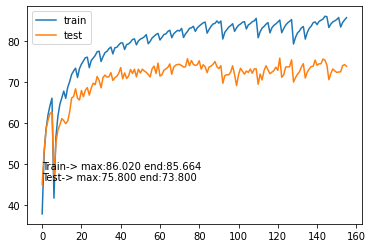

In [62]:
plt.plot(accs_all, label="train")
plt.plot(accs_test, label="test")
ymin, ymax = plt.gca().get_ylim()
plt.text(0, 0.8*ymin+0.2*ymax, f"Train-> max:{max(accs_all):.3f} end:{accs_all[-1]:.3f} \nTest-> max:{max(accs_test):.3f} end:{accs_test[-1]:.3f}")
                    
plt.legend()
plt.savefig("files/05_dycnn_cifar10_7.png")

In [ ]:
max(accs_test)

In [ ]:
max(accs_all)

In [ ]:
np.argmax(accs_test)

In [ ]:
len(accs_test)

In [ ]:
dynet.non_linearity.bias

In [ ]:
dynet.root_net.residual.fc0.residual.fc1.residual.activations